In [1]:
import os
import sys
import math
import string
import math
import time
from scipy import *
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import numpy as np
import numpy


class StopLoss:

    def __init__(self):
        self.QxFile = "qx.dat"
        print ('QxFile:' , self.QxFile)
        print("Plese enter new value:")
        strInput=sys.stdin.readline()
        strInput=strInput.strip() # Newline (\n) am Ende der Eingabe entfernen
        if strInput == "":
            print("Using above mentioned Parameter")
        else:
            self.QxFile = strInput

        self.InforceFile = "pk.dat"
        print('Inforce:' , self.InforceFile)
        print("Plese enter new value:")
        strInput=sys.stdin.readline()
        strInput=strInput.strip() # Newline (\n) am Ende der Eingabe entfernen
        if strInput == "":
            print("Using above mentioned Parameter")
        else:
            self.InforceFile = strInput

        self.ResultFile = "result.dat"
        print ('Result:' , self.ResultFile)
        print("Plese enter new value:")
        strInput=sys.stdin.readline()
        strInput=strInput.strip() # Newline (\n) am Ende der Eingabe entfernen
        if strInput == "":
            print("Using above mentioned Parameter")
        else:
            self.ResultFile = strInput

        self.delta = 2500.0
        self.nrclasses = 2**20 #2**22
        print (' Parameters \n ---------- \n')#            print alter, sex
        strTemp = " QxFile: %20s \n InForce %20s \n Delta : %20.0f \n Classes %20d \n Max Loss %20.4e \n \n" % (self.QxFile, self.InforceFile, self.delta, self.nrclasses,self.delta*self.nrclasses)
        print (strTemp)
        print ('Loading Data')#            print alter, sex
        self.qx = np.loadtxt(self.QxFile)
        self.pk = np.loadtxt(self.InforceFile)
#        print (self.qx)
#        print (self.pk)
        self.Now = time.time()

    def calclambda(self):
        # Funktion berechnet Paprameter Lambda for compoud poisson
        # use [lambda] = calclambda(pk,qx)
        actlam = 0
        for i in range(self.pk.shape[0]):
            alter = int(0.001+self.pk[i,0])
            sex   = int(0.001+self.pk[i,1])
            qxakt = self.qx[alter,sex]
            actlam = actlam + qxakt
        return(actlam) 

    def calcpois(self, ev, lam):
    #
    # berechnet gesamtschadenverteilung 
    # use [gv]= calcpois(ev, lambda, self.nrclasses)
    #
        gvfft = fft(ev)
        gvfft = np.exp(lam *(gvfft - 1))
        gv = np.real(ifft(gvfft))
        return(gv)

    def makeeinzelvert(self):
    #
    # Berechnet Einzzelschadenverteilung fuer pk
    # use  [ev] = makeeinzelvert(pk,self.qx,self.delta,self.nrclasses)
    #
        temp   = np.zeros([self.nrclasses], dtype='f')
        lam = 0.0
        for i in range(self.pk.shape[0]):
            alter  = int(0.001+self.pk[i,0])
            sex    = int(0.001+self.pk[i,1])
            qxakt  = self.qx[alter,sex]
            lam +=  qxakt
            leist  = self.pk[i,2]
            index  = round(leist / self.delta )
            temp[index] += qxakt
        return(temp / lam)

    def dojob(self):
        lam = self.calclambda()
        print("Lambda", lam)
        ev = self.makeeinzelvert()
#        fid2 = open("temp.dat","w")
#        scipy.io.write_array(fid2,  ev)
#        fid2.close()        
        gv = self.calcpois(ev, lam)
#        fid2 = open("temp.dat","w")
#        scipy.io.write_array(fid2,  gv)
#        fid2.close()
        print('Elased Time (FFT+Reading):', time.time()-self.Now)


        fid = open(self.ResultFile,'w')

        temp = 0.

        for i in range(self.pk.shape[0]):
            alter = int(0.001+self.pk[i,0])
            sex   = int(0.001+self.pk[i,1])
            qxakt = self.qx[alter,sex]
            leist = self.pk[i,2]
            temp += leist * qxakt
        ExpLoss = temp
        strOut = ""
        strLine = "\n Pensionskasse: N " + str(self.pk.shape[0])
        print (strLine)
        strOut += strLine
        strLine = "\n Erwartungswert: " + str(temp)
        print (strLine)
        strOut += strLine

        a= np.zeros([4,100], dtype='f')
        for i in range(80):
            a[0,i] = i * 0.05
        for i in range(80):    
            index  = int(round(a[0,i] * temp / self.delta ))
            p = sum(gv[range(index,self.nrclasses)])
            e = 0
#            print gv[range(index,self.nrclasses)].shape[0],gv[range(index,self.nrclasses)].shape[1]
            zz = np.asmatrix(np.array(range(index, self.nrclasses)).transpose())
            #print(zz.shape[0], zz.shape[1], len(gv[range(index,self.nrclasses)]))
            #print zz * gv[range(index,self.nrclasses)]
            e = self.delta * np.dot(zz[0,:],gv[range(index,self.nrclasses)])
            a[1,i] = index
            a[2,i] = p
            a[3,i]= e
            strLine = "\n " + str(a[0,i]) + " ES  Index "+ str(a[1,i]) +" Prob " + str(a[2,i]) +" E((S-X)+) " + str(a[3,i])
#            print strLine
            strOut += strLine
        fid.write(strOut)
        fid.close()
        index2 =  int(round(79 * 0.05 * ExpLoss / self.delta))
        aa= np.array(range(1,index2)) * self.delta
        plt.figure(2)
        plt.subplot(211)
        plt.plot(aa,gv[range(1,index2)],'r',label="Composite Distribution")
        plt.plot(aa,ev[range(1,index2)]/100,'b:', label ="Individual Distribution")
        plt.title('Distribution')
        plt.legend()
        ab= a[0,range(80)] * ExpLoss
        ac= 1 - a[2,range(80)]
        plt.subplot(212)
        plt.plot(ab, ac,'g', label="Probability", linewidth = 6)
        [XMin, XMax, YMin, YMax] = plt.axis()
        [XMin, XMax, YMin, YMax] = plt.axis([XMin, XMax, 0, 1 ])
        plt.title('CdF')
        for i in range(7):
            LocIndex = 10 * (i+1)
            xPos = 0.5*(XMax - XMin) + XMin
            yPos = ((6-i)+2)/10.*(YMax-YMin) + YMin
            if i == 6:
                MyText =  "1.0 x ES = %10.0f"  % (ExpLoss)
            else:
                MyText = str(a[0,LocIndex]) + " x ES --> Prob: %6.4f %20s %10.0f"  % (1-round(1e4*a[2,LocIndex])/1e4 ,'E[(S-X)+]:', round(a[3,LocIndex]))  
            plt.text(xPos, yPos, MyText)
        print ('Elased Time:', time.time()-self.Now)


QxFile: qx.dat
Plese enter new value:
Using above mentioned Parameter
Inforce: pk.dat
Plese enter new value:
Using above mentioned Parameter
Result: result.dat
Plese enter new value:
Using above mentioned Parameter
 Parameters 
 ---------- 

 QxFile:               qx.dat 
 InForce               pk.dat 
 Delta :                 2500 
 Classes              1048576 
 Max Loss           2.6214e+09 
 

Loading Data
Lambda 6.6241600000000185
Elased Time (FFT+Reading): 0.0422210693359375

 Pensionskasse: N 656

 Erwartungswert: 2119206.848339998


/var/folders/01/3sx_949s1jq1p4b651lcq1sm0000gn/T/ipykernel_72387/892737880.py:144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[3,i]= e


Elased Time: 11.136540174484253


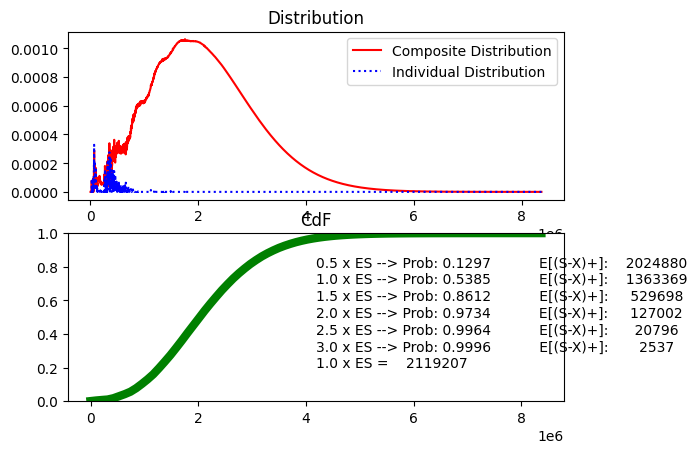

In [2]:
slp = StopLoss()
slp.dojob()